In [19]:
import os
import sys
from sys import path
sys.path.append(os.path.expanduser('~/albatros_analysis'))
import numpy as np 
import numba as nb
import time
from scipy import linalg
from scipy import stats
from matplotlib import pyplot as plt
from datetime import datetime as dt
from src.correlations import baseband_data_classes as bdc
from src.utils import baseband_utils as butils
from src.utils import orbcomm_utils as outils
from scipy.optimize import least_squares
import json

In [2]:
@nb.njit()
def get_common_rows(specnum0,specnum1,idxstart0,idxstart1):
    nrows0,nrows1=specnum0.shape[0],specnum1.shape[0]
    maxrows=min(nrows0,nrows1)
    rownums0=np.empty(maxrows,dtype='int64')
    rownums0[:]=-1
    rownums1=rownums0.copy()
    rowidx=rownums0.copy()
    i=0;j=0;row_count=0;
    while i<nrows0 and j<nrows1:
        if (specnum0[i]-idxstart0)==(specnum1[j]-idxstart1):
            rownums0[row_count]=i
            rownums1[row_count]=j
            rowidx[row_count]=specnum0[i]-idxstart0
            i+=1
            j+=1
            row_count+=1
        elif (specnum0[i]-idxstart0)>(specnum1[j]-idxstart1):
            j+=1
        else:
            i+=1
    return row_count,rownums0,rownums1,rowidx

@nb.njit(parallel=True)
def avg_xcorr_4bit_2ant_float(pol0,pol1,specnum0,specnum1,idxstart0,idxstart1,delay=None,freqs=None):
    row_count,rownums0,rownums1,rowidx=get_common_rows(specnum0,specnum1,idxstart0,idxstart1)
    ncols=pol0.shape[1]
#     print("ncols",ncols)
    assert pol0.shape[1]==pol1.shape[1]
    xcorr=np.zeros((row_count,ncols),dtype='complex64') # in the dev_gen_phases branch
    if delay is not None:
        for i in nb.prange(row_count):
            for j in range(ncols):
                xcorr[i,j] = pol0[rownums0[i],j]*np.conj(pol1[rownums1[i],j]*np.exp(2j*np.pi*delay[rowidx[i]]*freqs[j]))
    else:
        for i in nb.prange(row_count):
            xcorr[i,:] = pol0[rownums0[i],:]*np.conj(pol1[rownums1[i],:])
    return xcorr

def get_coarse_xcorr(f1, f2, Npfb=4096):
    if len(f1.shape) == 1:
        f1 = f1.reshape(-1, 1)
    if len(f2.shape) == 1:
        f2 = f2.reshape(-1, 1)
    chans = f1.shape[1]
    Nsmall = f1.shape[0]
    wt = np.zeros(2 * Nsmall)
    wt[:Nsmall] = 1
    n_avg = np.fft.irfft(np.fft.rfft(wt) * np.conj(np.fft.rfft(wt)))
#     print(n_avg)
#     n_avg[Nsmall] = np.nan
#     print(n_avg[Nsmall-10:Nsmall+10])
    n_avg = np.tile(n_avg, chans).reshape(chans, 2*Nsmall)
#     print(n_avg.shape)
    bigf1 = np.vstack([f1, np.zeros(f1.shape, dtype=f1.dtype)])
    bigf2 = np.vstack([f2, np.zeros(f2.shape, dtype=f2.dtype)])
    bigf1 = bigf1.T.copy()
    bigf2 = bigf2.T.copy()
    bigf1f = np.fft.fft(bigf1,axis=1)
    bigf2f = np.fft.fft(bigf2,axis=1)
    xx = bigf1f * np.conj(bigf2f)
    xcorr = np.fft.ifft(xx,axis=1)
    xcorr = xcorr / n_avg
    xcorr[:,Nsmall] = np.nan
    return xcorr

def phase_pred(fit_coords, info, pulse_idx):
    
    ref_coords = coords[0]

    relative_start_time = info[pulse_idx][0][0]
    pulse_duration_sec = info[pulse_idx][0][1] - info[pulse_idx][0][0]
    pulse_duration_chunks = int( pulse_duration_sec / (T_SPECTRA * v_acclen) )


    time_start = global_start_time + relative_start_time
    sat_ID = info[pulse_idx][1]

    pulse_channel_idx = info[pulse_idx][2]
    pulse_freq = outils.chan2freq(pulse_channel_idx, alias=True)

    # 'd' has one entry per second
    d = outils.get_sat_delay(ref_coords, fit_coords, tle_path, time_start, visibility_window+1, sat_ID)
    # 'delay' has one entry per chunk (~0.5s) 
    delay = np.interp(np.arange(0, v_nchunks) * v_acclen * T_SPECTRA, np.arange(0, int(visibility_window)+1), d)
    #thus 'pred' has one entry for each chunk
    pred = (-delay[:pulse_duration_chunks]+ delay[0]) *  2*np.pi * pulse_freq

    return pred

def get_residuals(coordinates):
    all_res = []
    for pulse_idx, observed_data in enumerate(data):
        predicted = phase_predictor(coordinates, pulse_idx)
        res = predicted - observed_data
        all_res.append(res)
    return np.concatenate(all_res)  # Returns a single long 1D array

STANDARDIZED INITIAL VARBS

In [3]:
T_SPECTRA = 4096/250e6

visibility_window = 1000

c_acclen = 10**6 
v_acclen = 30000

C_T_ACCLEN = c_acclen* T_SPECTRA
V_T_ACCLEN = v_acclen* T_SPECTRA

c_nchunks = int((visibility_window)/C_T_ACCLEN)
v_nchunks = int((visibility_window)/V_T_ACCLEN)

#---------Data-specific--------

data_version = "MANUAL TESTER 2"

if data_version == "MANUAL TESTER":

    a1_path = "/scratch/s/sievers/mohanagr/mars1_2024/baseband/"
    a2_path = "/scratch/s/sievers/mohanagr/mars2_2024/baseband/"

    global_start_time = 1721800002

    a1_coords = [79+25.031/60, -90-46.041/60, 189]  # MARS 1
    a2_coords = [79+25.033/60, -90-45.531/60, 176]  # MARS 2

if data_version == "MANUAL TESTER 2":

    a1_path = "/scratch/s/sievers/mohanagr/mars1_2024/baseband/"
    a2_path = "/scratch/s/sievers/mohanagr/mars2_2024/baseband/"

    global_start_time = 1721900002

    a1_coords = [79+25.031/60, -90-46.041/60, 189]  # MARS 1
    a2_coords = [79+25.033/60, -90-45.531/60, 176]  # MARS 2

elif data_version == "SATDET TESTER":

    a1_coords = [79.41718333333333, -90.76735, 189]
    a2_coords = [79.41721666666666, -90.75885, 176] #ant2
    a3_coords = [79.41541666666667, -90.77308333333333, 175] #ant3

    a1_path = "/project/s/sievers/albatros/mars/202307/baseband/stn_1_central"
    a2_path = "/project/s/sievers/albatros/mars/202307/baseband/stn_2_east" #ant2
    a3_path = "/project/s/sievers/albatros/mars/202307/baseband/stn_3_west" #ant3

    global_start_time = 1699625045


tle_path = outils.get_tle_file(global_start_time, "/project/s/sievers/mohanagr/OCOMM_TLES")

dir_parents = []
dir_parents.append(a1_path)
dir_parents.append(a2_path)

coords = []
coords.append(a1_coords)
coords.append(a2_coords)

In [4]:
with open("pulsedata_1721900002_1748541899.json", "r") as f:
    pulsedata = json.load(f)
    
    info = []
    for pulse_idx, details in enumerate(pulsedata["1721900002"]["antenna 1"]):
        #print(f"\n--------pulse idx {pulse_idx}---------")
        start_time = details["start"] * 5
        end_time = details["end"] * 5

        #timestream_offset = details["timestream_offset"]

        for satID, values in details["sats_present"].items():
            #
            # print(satID)
            for i in range(len(values)):
                pulse_info = []
                #print(values[i])
                chan = values[i][0]
                corr_offset = values[i][1]
                rel = values[i][2][0]

                pulse_info.append([start_time, end_time])
                pulse_info.append(int(satID))
                pulse_info.append(chan)
                pulse_info.append(corr_offset)

                info.append(pulse_info)
            
print(info)



[[[2110, 2630], 59051, 1836, 103156], [[2110, 2630], 59051, 1837, 103156], [[6920, 7230], 25338, 1841, 79705], [[8135, 8680], 59051, 1836, 79731], [[8135, 8680], 59051, 1837, 79731], [[12925, 13380], 25338, 1841, 79705], [[13600, 13905], 33591, 1849, 79730], [[13600, 13905], 33591, 1850, 79705], [[14150, 14695], 59051, 1836, 79731], [[14150, 14695], 59051, 1837, 79731], [[14870, 15215], 57166, 1836, 79731], [[14870, 15215], 57166, 1837, 79731], [[17330, 17605], 28654, 1836, 79705], [[17330, 17605], 28654, 1837, 79730]]


In [5]:
#all these are detected. These numbers are the result of all the stuff above. What we care about starts now.


#if data_version == "MANUAL TESTER":
        #info = [[[715, 1110], 28654, 1836, 86568], 
                #[[4950, 5270], 59051, 1836, 109993], 
               # [[7000, 7145], 28654, 1836, 109993], 
                #[[10975, 11350],59051, 1836, 86568],
                #[[17005, 17530], 59051, 1837, 86568] ]

#if data_version == "MANUAL TESTER 2":
        #info = [[[2110, 2630], 59051, 1836, 103156], 
               # [[6920, 7230], 25338, 1841, 79705], 
                #[[8135, 8680], 59051, 1836, 79731], 
                #[[13600, 13905],33591, 1849, 79730],
                #[[14870, 15215], 57166, 1837, 79731] ]

#elif data_version == "SATDET TESTER":
        #info = [[[0, 215], 33591, 16, 77396]]
                
                #[[505, 765], 28654, 2, 67385],
                #[[1815, 2250], 57166, 2, 53673],
                #[[4730, 4940], 25338, 7, 71541]]


In [6]:
observed_data = []
time_total = time.time()
for pulse_idx in range(len(info)):

    print(f"---------STARTING PULSE {pulse_idx}---------")

    #--------times-----
    relative_start_time = info[pulse_idx][0][0]
    pulse_duration_chunks = int(  (info[pulse_idx][0][1] - info[pulse_idx][0][0]) / (T_SPECTRA * v_acclen)  )
    t_start = global_start_time + relative_start_time
    t_end = t_start + visibility_window

    #----get initialized information----
    files_a1, idx1 = butils.get_init_info(t_start, t_end, a1_path)
    files_a2, idx2 = butils.get_init_info(t_start, t_end, a2_path)

    #------get corrected offsets-----
    idx_correction = info[pulse_idx][3] - 100000
    if idx_correction>0:
        idx1_v = idx1 + idx_correction
        idx2_v = idx2
    else:
        idx2_v = idx2 + np.abs(idx_correction)
        idx1_v = idx1
    #print("Corrected Starting Indices:", idx1_v, idx2_v)

    #-------set up channels-------
    channels = bdc.get_header(files_a1[0])["channels"].astype('int64')
    chanstart = np.where(channels == 1834)[0][0] 
    chanend = np.where(channels == 1852)[0][0]
    nchans=chanend-chanstart

    chan_bigidx = info[pulse_idx][2]
    chanmap = channels[chanstart:chanend].astype(int)
    chan_smallidx = np.where(chanmap == chan_bigidx)[0][0]

    #--------open object----------
    ant1 = bdc.BasebandFileIterator(files_a1, 0, idx1_v, v_acclen, nchunks= v_nchunks, chanstart = chanstart, chanend = chanend, type='float')
    ant2 = bdc.BasebandFileIterator(files_a2, 0, idx2_v, v_acclen, nchunks= v_nchunks, chanstart = chanstart, chanend = chanend, type='float')

    #--------get visibilities-----
    m1=ant1.spec_num_start
    m2=ant2.spec_num_start

    visibility_phased = np.zeros((v_nchunks,len(ant1.channel_idxs)), dtype='complex64')
    time_pulse=time.time()
    #print(f"--------- Processing Pulse Idx {pulse_idx} ---------")
    for i, (chunk1,chunk2) in enumerate(zip(ant1,ant2)):
            xcorr = avg_xcorr_4bit_2ant_float(
                chunk1['pol0'], 
                chunk2['pol0'],
                chunk1['specnums'],
                chunk2['specnums'],
                m1+i*v_acclen,
                m2+i*v_acclen)
            visibility_phased[i,:] = np.sum(xcorr,axis=0)/v_acclen
            #print("CHUNK", i, " has ", xcorr.shape[0], " rows")
    print(f"DONE PULSE {pulse_idx}. TIME:", time.time()-time_pulse)
    visibility_phased = np.ma.masked_invalid(visibility_phased)
    vis_phase = np.angle(visibility_phased)
    obs = np.unwrap(vis_phase[0:pulse_duration_chunks, chan_smallidx])
    observed_data.append(obs)

    if pulse_idx == 6:
        break
    
print("Done with everything. Time taken:", time.time() - time_total)

---------STARTING PULSE 0---------
Not reading any data
ACCLEN RECEIVED IS 30000
took 0.179 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17219/1721902074.raw
START SPECNUM IS 3974795990 obj start at 3972473498
ACCLEN RECEIVED IS 30000
took 0.158 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17219/1721902111.raw
START SPECNUM IS 3981020766 obj start at 3980959731
took 0.289 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17219/1721902118.raw
took 0.202 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17219/1721902156.raw
took 0.285 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17219/1721902163.raw
took 0.283 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17219/1721902200.raw
took 0.245 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17219/1721902207.raw
took 0.177 seconds to read 

0
catalog #59051 epoch 2024-07-25 21:33:51 UTC
1
catalog #59051 epoch 2024-07-25 21:33:51 UTC
2
catalog #25338 epoch 2024-07-25 21:09:12 UTC
3
catalog #59051 epoch 2024-07-25 21:33:51 UTC
4
catalog #59051 epoch 2024-07-25 21:33:51 UTC
5
catalog #25338 epoch 2024-07-25 21:09:12 UTC
6
catalog #33591 epoch 2024-07-25 21:24:09 UTC


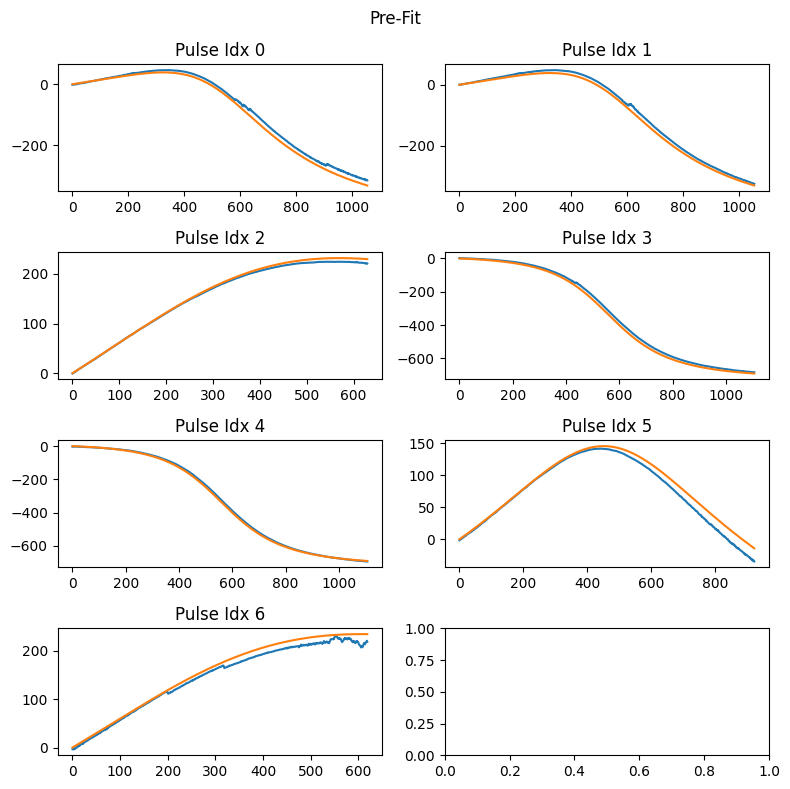

In [7]:
fig, ax = plt.subplots(int(np.ceil(len(observed_data)/2)), 2)
fig.set_size_inches(8, 8)
ax = ax.flatten()
fig.suptitle(f"Pre-Fit")
for pulse_idx in range(len(observed_data)):
    print(pulse_idx)
    predicted_data = phase_pred(a2_coords, info, pulse_idx)
    ax[pulse_idx].set_title(f"Pulse Idx {pulse_idx}")
    ax[pulse_idx].plot(observed_data[pulse_idx])
    ax[pulse_idx].plot(predicted_data)
plt.tight_layout()
#fig.savefig(path.join(out_path,f"pre_fit_calib_plots_{tstart}.jpg"))
#print(path.join(out_path,f"dg_cxcorr_{tstart}_{pstart}_{pend}.jpg"))

In [14]:
def residuals_all(coords, observed_data, phase_pred, info):
    
    #gets all residuals in one long array
    residuals_all = []

    for pulse_idx, observed in enumerate(observed_data):
        
        predicted = phase_pred(coords, info, pulse_idx)  
        res = observed - predicted
        residuals_all.append(res.flatten())  # Flatten for least squares fitting

    return np.concatenate(residuals_all)

def residuals_individual(coords, observed_data, phase_pred, info, pulse_idx):
    predicted = phase_pred(coords, info, pulse_idx)
    res = observed_data[pulse_idx] - predicted
    
    return res


In [15]:
def fitting_trf(observed_data, initial_coordinates, phase_pred, info):

    result = least_squares(
        lambda coords: residuals_all(coords, observed_data, phase_pred, info),  # Pass a lambda that calls residuals
        initial_coordinates,
        method = 'trf'
    )
    
    optimized_coordinates = result.x
    return optimized_coordinates, result

def fitting_lm(observed_data, initial_coordinates, phase_pred, info):

    result = least_squares(
        lambda coords: residuals_all(coords, observed_data, phase_pred, info),  # Pass a lambda that calls residuals
        initial_coordinates,
        method = 'lm'
    )
    
    optimized_coordinates = result.x
    return optimized_coordinates, result




In [16]:
fitted_coords_trf = fitting_trf(observed_data, a2_coords, phase_pred, info)[0]
fitted_coords_lm = fitting_lm(observed_data, a2_coords, phase_pred, info)[0]

catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #5

[('tlm', array([ 79.41722658, -90.75901238, 183.92610356])), ('lm', array([ 79.41722658, -90.75901238, 183.92599745]))]
('tlm', array([ 79.41722658, -90.75901238, 183.92610356]))
tlm
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
saved residual plot to: /project/s/sievers/thomasb/may_29/residuals_combined_tlm_coordfit_1721900002.jpg
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #59051 epoch 2024-07-25 21:33

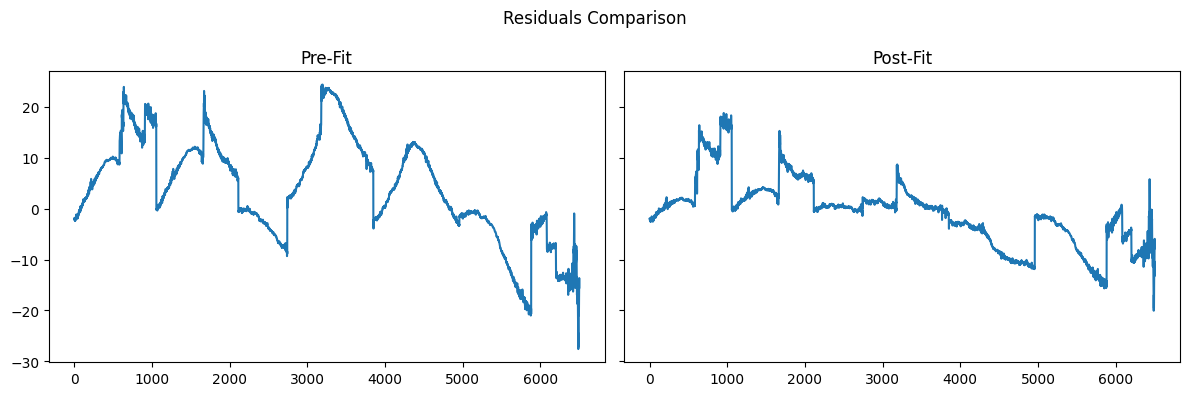

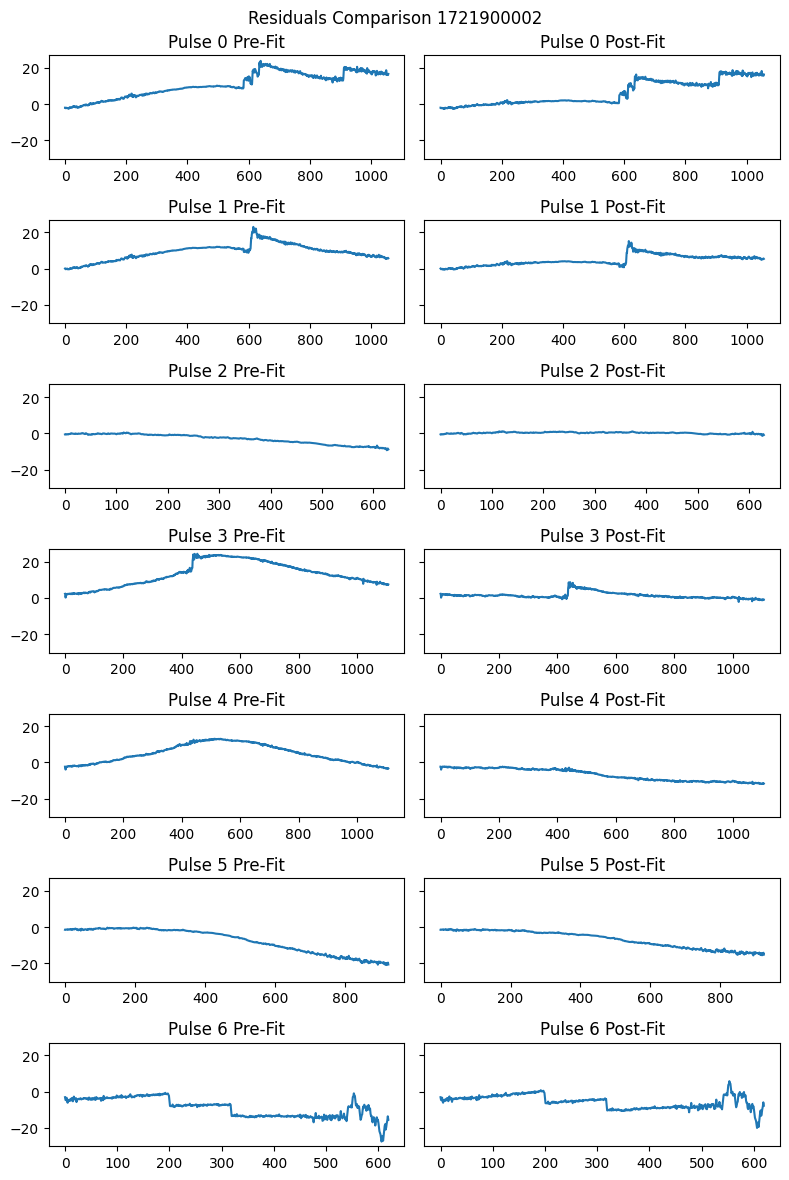

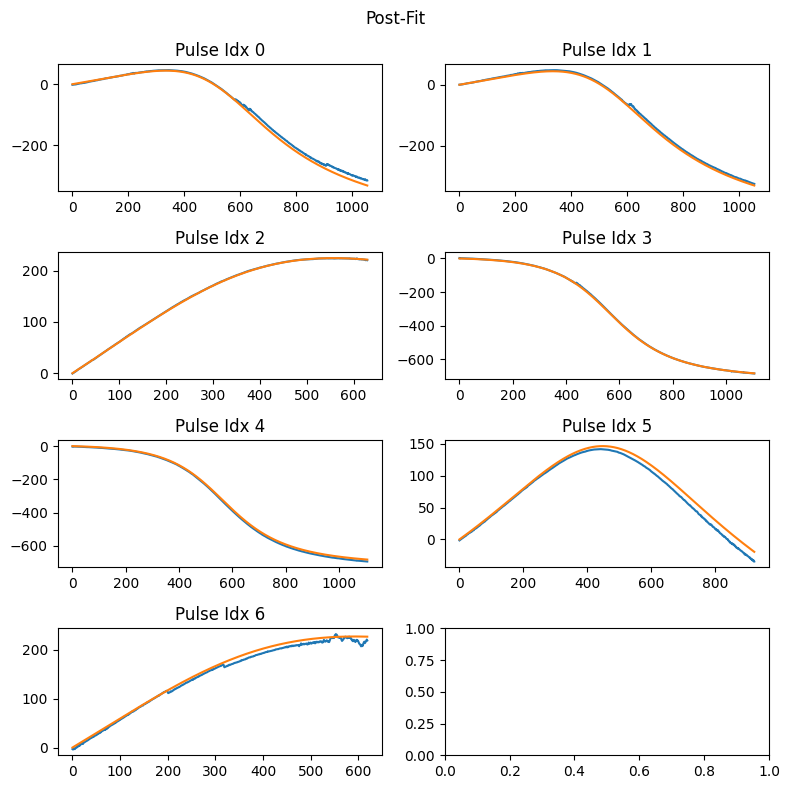

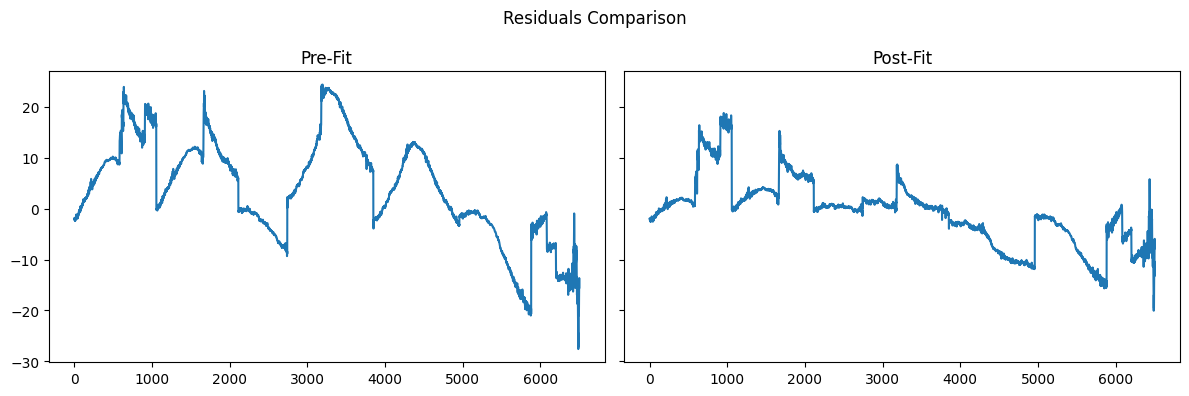

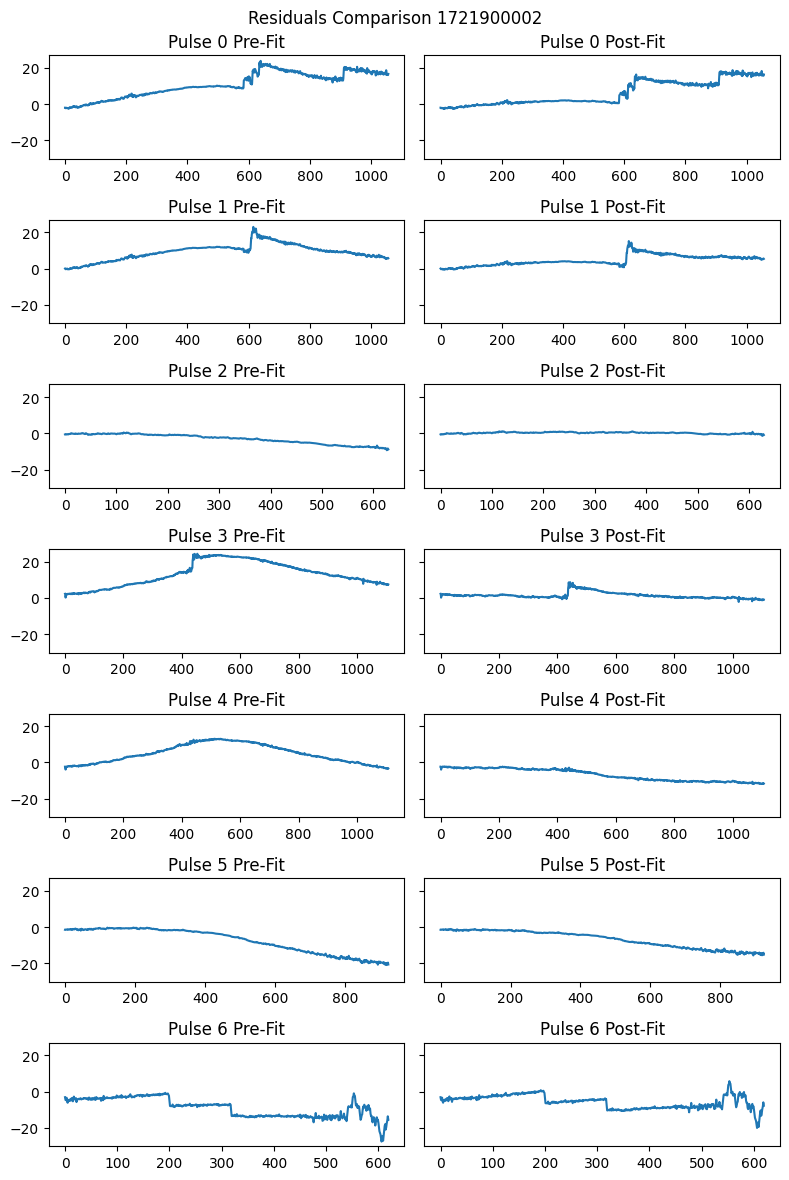

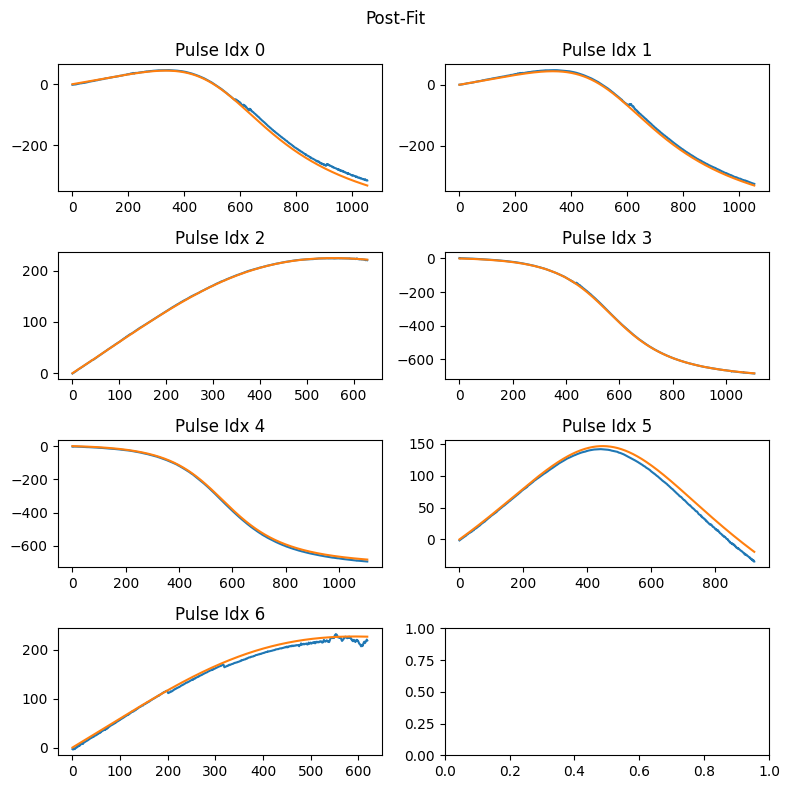

In [34]:
out_path = "/project/s/sievers/thomasb/may_29"
argument = 'both'
fit_types = []
if (argument == 'trf') or (argument == 'both'):
    fit_types.append(('tlm', fitted_coords_trf))
if (argument == 'lm') or (argument == 'both'):
    fit_types.append(('lm', fitted_coords_lm))


print(fit_types)
for fit_type_tuple in fit_types:
    print(fit_type_tuple)
    print(fit_type_tuple[0])

    #combined residuals
    fig, ax = plt.subplots(1,2, sharey=True)
    fig.set_size_inches(12, 4)
    ax = ax.flatten()
    fig.suptitle("Residuals Comparison")  #add start time into title!!
    ax[0].plot(residuals_all(a2_coords, observed_data, phase_pred, info))
    ax[0].set_title("Pre-Fit")
    ax[1].plot(residuals_all(fit_type_tuple[1], observed_data, phase_pred, info))
    ax[1].set_title("Post-Fit")
    plt.tight_layout()
    fig.savefig(os.path.join(out_path,f"residuals_combined_{fit_type_tuple[0]}_coordfit_{global_start_time}.jpg"))
    print("saved residual plot to:", os.path.join(out_path,f"residuals_combined_{fit_type_tuple[0]}_coordfit_{global_start_time}.jpg"))

    #individual residuals
    fig, ax = plt.subplots(len(observed_data),2, sharey=True)
    fig.set_size_inches(8, 12)
    ax = ax.flatten()
    fig.suptitle(f"Residuals Comparison {global_start_time}")
    for i in range(len(observed_data)):  

        ax[2*i].plot(residuals_individual(a2_coords, observed_data, phase_pred, info, i))
        ax[2*i].set_title(f"Pulse {i} Pre-Fit")

        ax[2*i +1].plot(residuals_individual(fit_type_tuple[1], observed_data, phase_pred, info, i))
        ax[2*i +1].set_title(f"Pulse {i} Post-Fit")

    fig.tight_layout()
    fig.savefig(os.path.join(out_path,f"residuals_individual_{fit_type_tuple[0]}_coordfit_{global_start_time}.jpg"))
    print("saved residual plot to:", os.path.join(out_path,f"residuals_individual_{fit_type_tuple[0]}_coordfit_{global_start_time}.jpg"))


    fig, ax = plt.subplots(int(np.ceil(len(observed_data)/2)), 2)
    fig.set_size_inches(8, 8)
    ax = ax.flatten()
    fig.suptitle(f"Post-Fit")
    for pulse_idx in range(len(observed_data)):
        print(pulse_idx)
        predicted_data = phase_pred(fit_type_tuple[1], info, pulse_idx)
        ax[pulse_idx].set_title(f"Pulse Idx {pulse_idx}")
        ax[pulse_idx].plot(observed_data[pulse_idx])
        ax[pulse_idx].plot(predicted_data)
    plt.tight_layout()
    fig.savefig(os.path.join(out_path,f"post_fit_calib_plots_{fit_type_tuple[0]}_{global_start_time}.jpg"))
    print(os.path.join(out_path,f"post_fit_calib_plots_{fit_type_tuple[0]}_{global_start_time}.jpg"))

In [ ]:
fitted_coords_lm = fitting_lm(observed_data, a2_coords, phase_pred, info)[0]

catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC


catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #5

In [ ]:
print(a2_coords)
print(fitted_coords_trf)
print(fitted_coords_lm)

[79.41721666666666, -90.75885, 176]
[ 79.41722444 -90.75885452 185.23205535]
[ 79.41722444 -90.75885452 185.2322104 ]


catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC


Text(0.5, 1.0, 'Post-Fit')

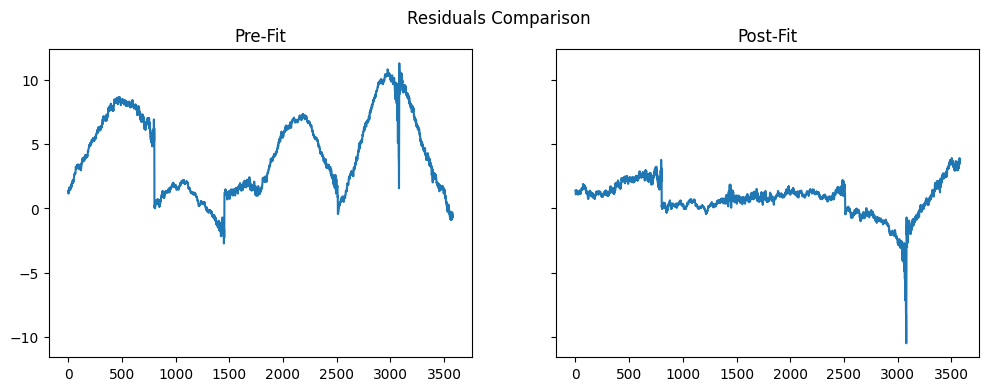

In [ ]:
fig, ax = plt.subplots(1,2, sharey=True)
fig.set_size_inches(12, 4)
ax = ax.flatten()
fig.suptitle("Residuals Comparison")  #add start time into title!!
ax[0].plot(residuals(a2_coords, observed_data, phase_pred, info))
ax[0].set_title("Pre-Fit")
ax[1].plot(residuals(fitted_coords, observed_data, phase_pred, info))
ax[1].set_title("Post-Fit")


catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC


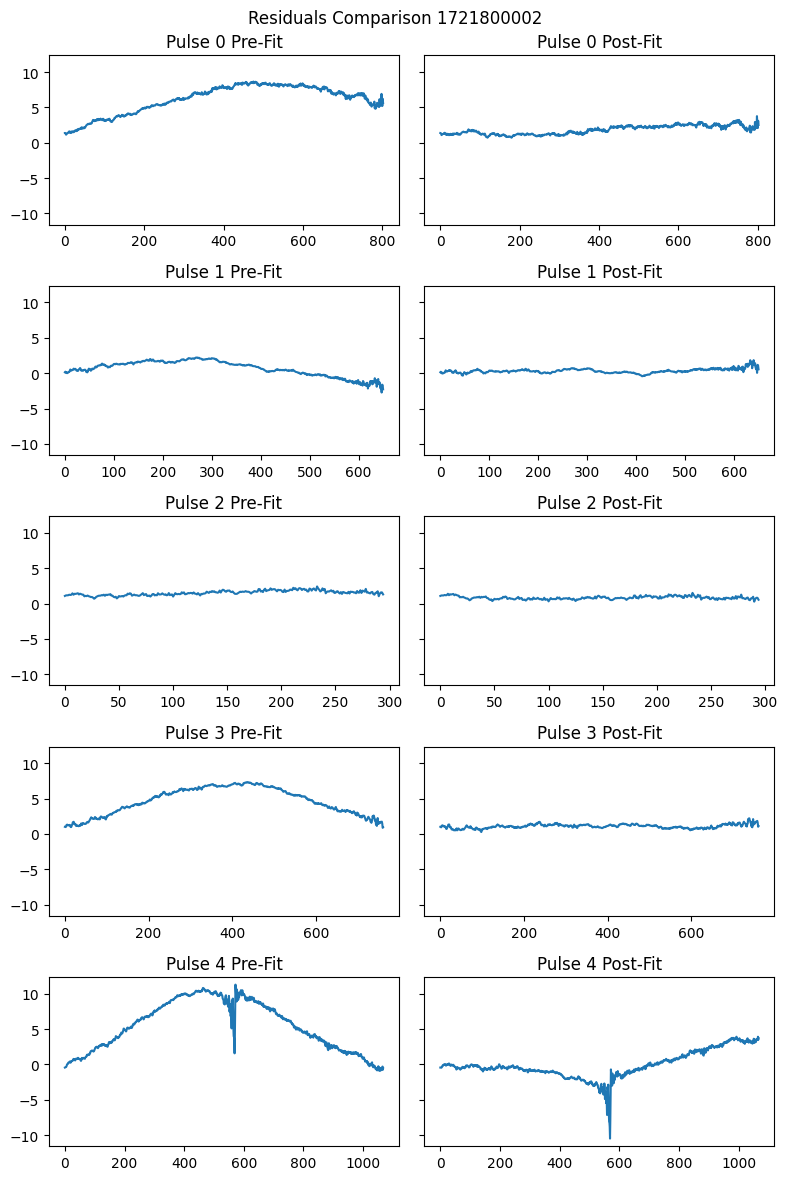

In [ ]:
fig, ax = plt.subplots(len(observed_data),2, sharey=True)
fig.set_size_inches(8, 12)
ax = ax.flatten()
fig.suptitle(f"Residuals Comparison {global_start_time}")
for i in range(len(observed_data)):  

    ax[2*i].plot(residuals_individual(a2_coords, observed_data, phase_pred, info, i))
    ax[2*i].set_title(f"Pulse {i} Pre-Fit")

    ax[2*i +1].plot(residuals_individual(fitted_coords, observed_data, phase_pred, info, i))
    ax[2*i +1].set_title(f"Pulse {i} Post-Fit")

fig.tight_layout()

#fig.savefig(path.join(out_path,f"residuals_coordfit_{global_start_time}.jpg"))
#print("saved residual plot to:", path.join(out_path,f"residuals_coordfit_{global_start_time}.jpg"))


catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC


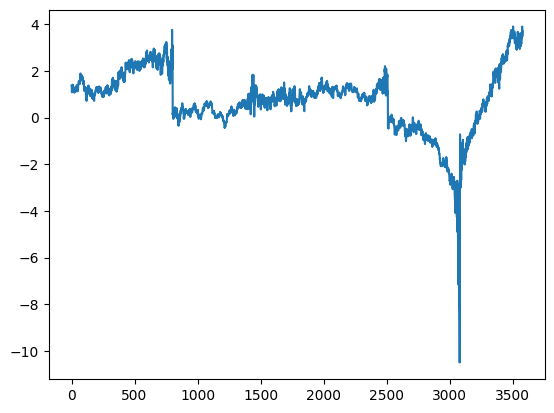

In [73]:
resids = residuals(fitted_coords, observed_data, phase_pred, info)
plt.plot(resids)

catalog #59051 epoch 2024-07-24 21:55:34 UTC


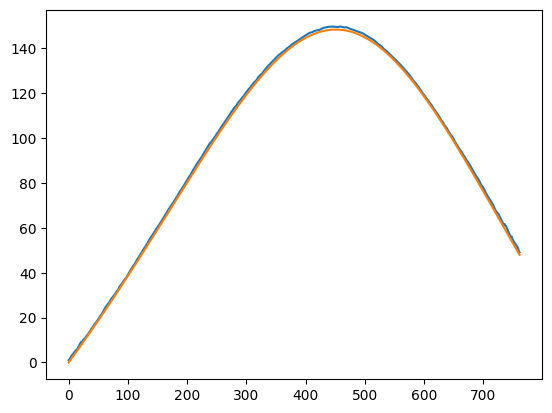

In [65]:
idx = 3

plt.plot(observed_data[idx])

plt.plot(phase_pred(fitted_coords, info, idx))

0
catalog #28654 epoch 2024-07-24 20:56:55 UTC
1
catalog #59051 epoch 2024-07-24 21:55:34 UTC
2
catalog #28654 epoch 2024-07-24 20:56:55 UTC
3
catalog #59051 epoch 2024-07-24 21:55:34 UTC
4
catalog #59051 epoch 2024-07-24 21:55:34 UTC


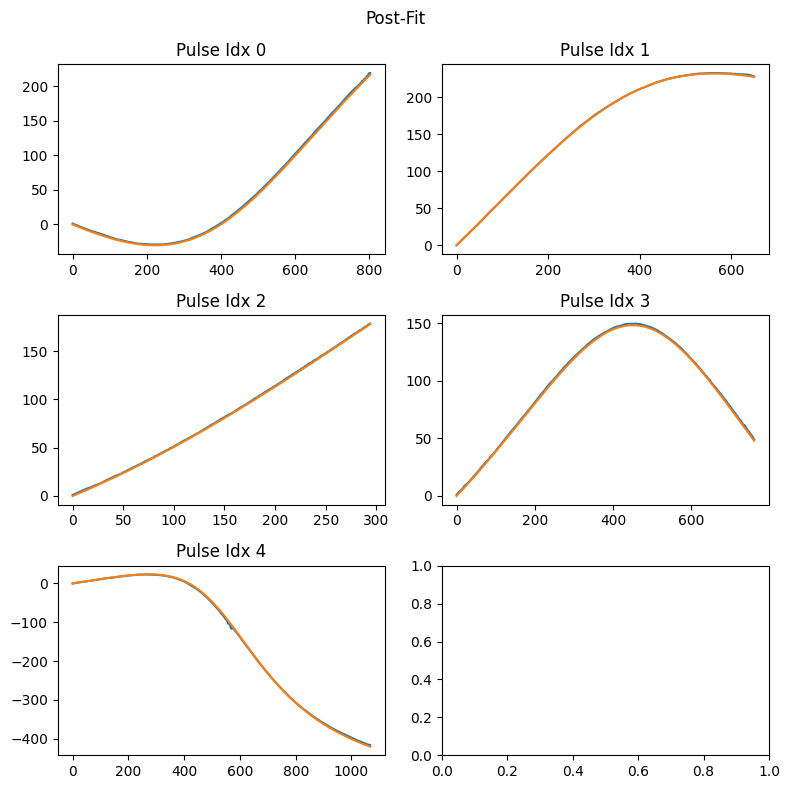

In [77]:
fig, ax = plt.subplots(int(np.ceil(len(observed_data)/2)), 2)
fig.set_size_inches(8, 8)
ax = ax.flatten()
fig.suptitle(f"Post-Fit")
for pulse_idx in range(len(observed_data)):
    print(pulse_idx)
    predicted_data = phase_pred(fitted_coords, info, pulse_idx)
    ax[pulse_idx].set_title(f"Pulse Idx {pulse_idx}")
    ax[pulse_idx].plot(observed_data[pulse_idx])
    ax[pulse_idx].plot(predicted_data)
plt.tight_layout()
#fig.savefig(path.join(out_path,f"pre_fit_calib_plots_{tstart}.jpg"))
#print(path.join(out_path,f"dg_cxcorr_{tstart}_{pstart}_{pend}.jpg"))